<a href="https://colab.research.google.com/github/morenourey/DSC_NUCLIO/blob/main/ML_2_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SUP ML 2 - MODEL

# Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings("ignore")


In [ ]:
pip install catboost

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
# algoritmos de clasificación
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# algoritmos de regresión
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
# metricas
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Carga clean data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_predict = pd.read_csv('/content/drive/MyDrive/NUCLIO/Entregable 2/df_predict_reduced.csv')

df_train = pd.read_csv('/content/drive/MyDrive/NUCLIO/Entregable 2/df_test_reduced.csv')

# Split X-y

In [ ]:
target = 'churn'

In [ ]:
# En clasificación, el target es booleano (True/False)
df_train[target] = df_train[target].astype('bool')

In [ ]:
features = [i for i in df_train.columns if i != target]

In [ ]:
y = df_train[target]
X = df_train[features]

# Distribución del target

In [ ]:
y.value_counts() / df_train.shape[0]  # Distribucion en %

churn
True     0.511807
False    0.488193
Name: count, dtype: float64

# Undersampling (*)

**NOTA:** SOLO EN CLASIFICACIÓN cuando el ratio de éxitos está MUY DESBALANCEADO (<10%).

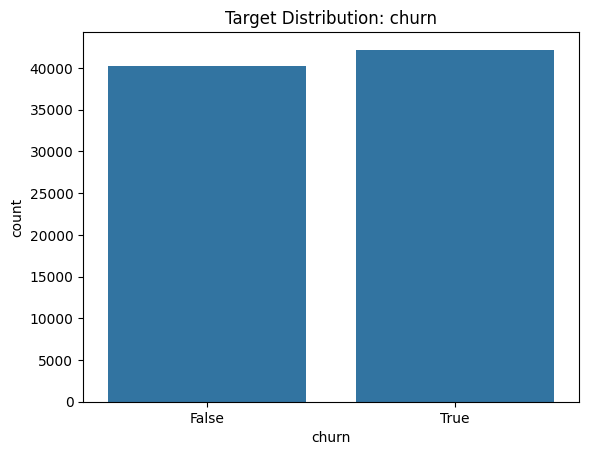

In [ ]:
sns.countplot(x=y)
plt.title('Target Distribution: '+target) #Notamos que la target está balanceada
plt.show()

# Split TRAIN-TEST

In [ ]:
# se guarda un 30% de datos para el test y un 70% para el train
y = df_train['churn']
X = df_train.drop('churn', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Rescaling

* NO NECESARIO en modelos de Arboles de Decisión.
* Guardar scaler en el model path.

In [ ]:
# Hemos realizado ya el rescaling mediante la técnica de MinMaxScaler en ML 1 - Preprocessing, por lo tanto no es necesario hacer rescaling en ML 2 - Model

# TRAIN-VALIDA

## Torneo de Modelos

* Probamos una colección de modelos con el objetivo de conseguir el mejor rendimiento del modelo en los datos de VALIDACION.

In [ ]:
def medicion(y_t, y_p):
  """imprime la curva ROC y el AUC"""
  # calculate the fpr and tpr for all thresholds of the classification
  fpr, tpr, threshold = metrics.roc_curve(y_t, y_p)
  roc_auc = metrics.auc(fpr, tpr)
  # para añadir el gráfico
  # method I: plt
  import matplotlib.pyplot as plt
  plt.figure(figsize=(8, 6))
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return roc_auc

In [ ]:
def entrenar(Xtrain, Xtest, ytrain, ytest):
  """entrena 6 módelos.
      imprime la curva roc de cada módelo junto al valor AUC
      devuelve un dataframe con los valores de AUC redondeados a 5 decimales para cada módelo"""
  # creamos la lista de auc vacía
  lista_aucs = []
  # Support Vector Machine
  print('Support Vector Machine')
  svclassifier = SVC(max_iter=20)
  svclassifier.fit(Xtrain, ytrain)
  y_pred = svclassifier.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('SVC', round(roc_auc, 5)))
  # Regresión logística
  print('Regresión logística')
  lr = LogisticRegression(max_iter=40)
  lr.fit(Xtrain, ytrain)
  y_pred = lr.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('regresión logística', round(roc_auc, 5)))
  # RidgeClassifier
  print('RidgeClassifier')
  rc = RidgeClassifier(max_iter=40)
  rc.fit(Xtrain, ytrain)
  y_pred = rc.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('RidgeClassifier', round(roc_auc, 5)))
  # Decision tree classsifier
  print('Decision tree classsifier')
  dt_base = DecisionTreeClassifier(random_state=42)
  dt_base.fit(Xtrain, ytrain)
  y_pred = dt_base.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('decision tree classifier', round(roc_auc, 5)))
  # Random forest
  print('Random forest')
  rf_base = RandomForestClassifier(random_state=42)
  rf_base.fit(Xtrain, ytrain)
  y_pred = rf_base.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('random forest', round(roc_auc, 5)))
  # Gradient boosting
  print('Gradient boosting')
  gbc_base = GradientBoostingClassifier(random_state=42)
  gbc_base.fit(Xtrain, ytrain)
  y_pred = gbc_base.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('gradient boosting', round(roc_auc, 5)))
  # XGBClassifier
  print('XGBClassifier')
  xgbc_base = XGBClassifier(random_state=42)
  xgbc_base.fit(Xtrain, ytrain)
  y_pred = xgbc_base.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('XGB classifier', round(roc_auc, 5)))
  # CatBoostClassifier
  print('CatBoostClassifier')
  cat_base = CatBoostClassifier(verbose=False, random_state=42)
  cat_base.fit(Xtrain, ytrain)
  y_pred = cat_base.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('CatBoost Classifier', round(roc_auc, 5)))
  df_aucs = pd.DataFrame(lista_aucs, columns=['modelos', 'AUC'])
  df_aucs = df_aucs.set_index('modelos')
  return df_aucs

Support Vector Machine


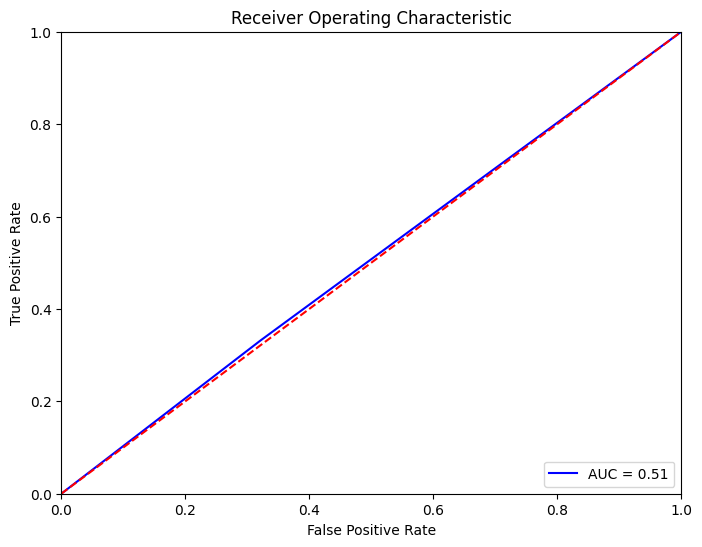

Regresión logística


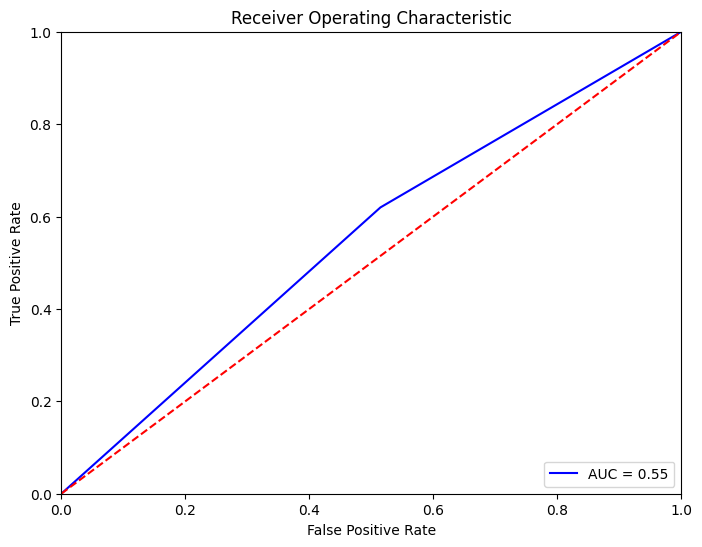

RidgeClassifier


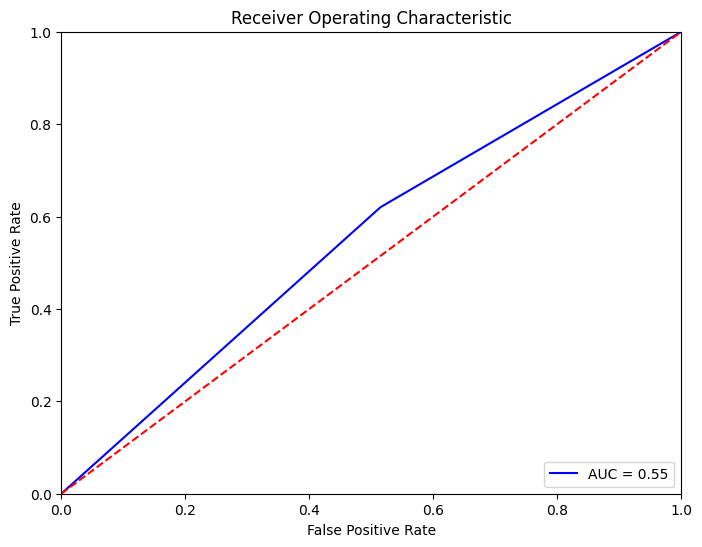

Decision tree classsifier


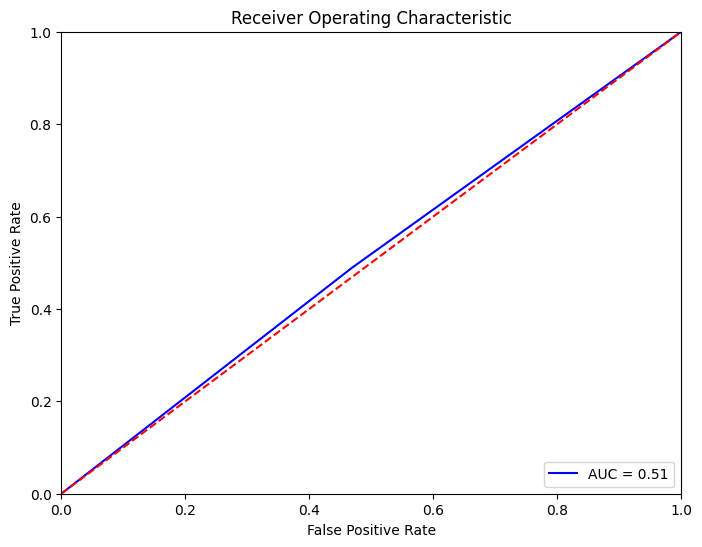

Random forest


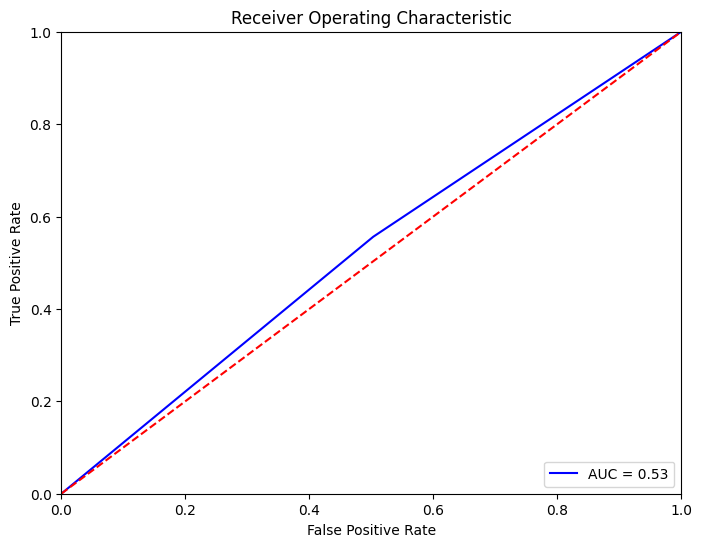

Gradient boosting


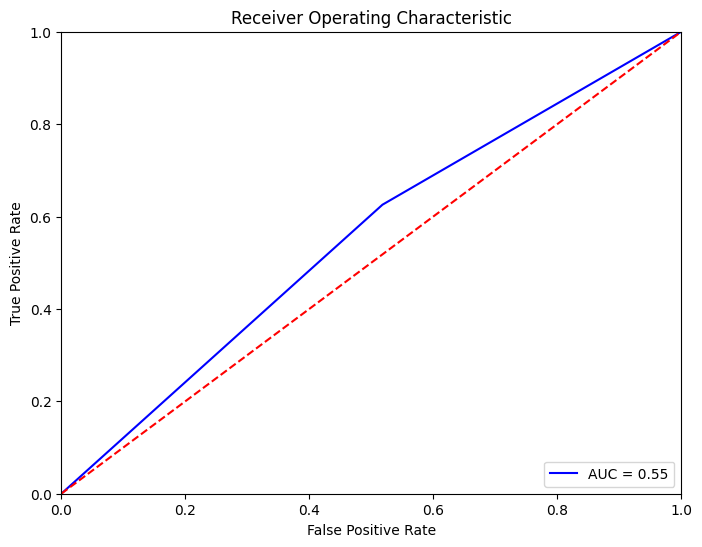

XGBClassifier


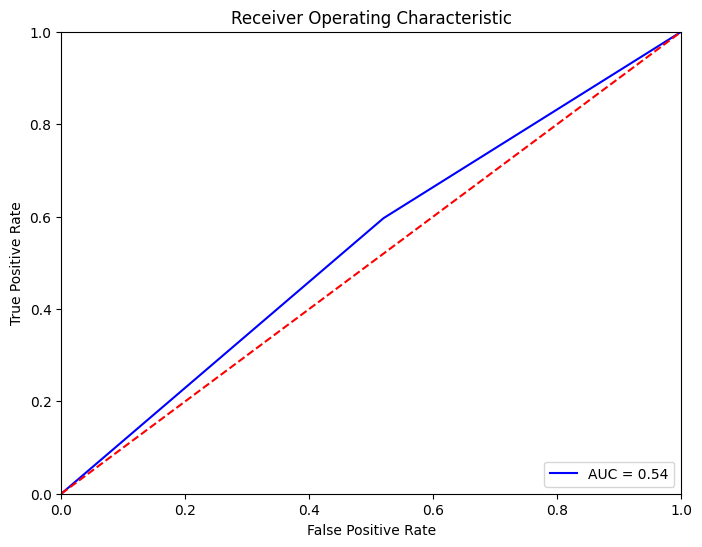

CatBoostClassifier


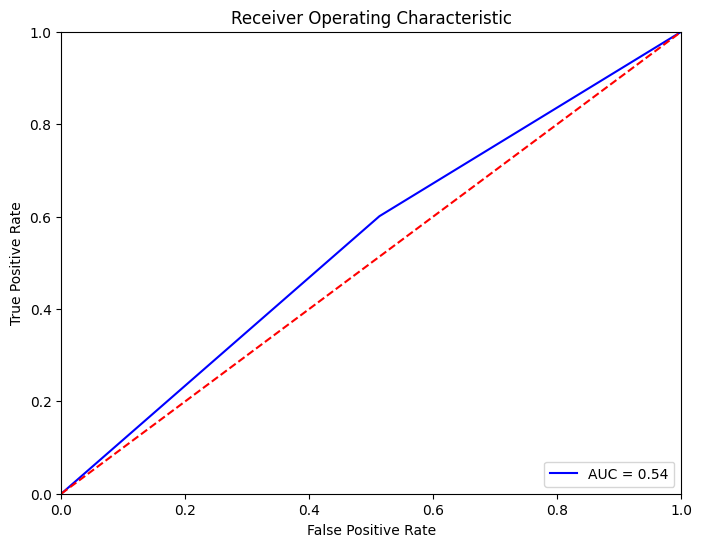

In [ ]:
aucs = entrenar(X_train, X_test, y_train, y_test)

In [ ]:
aucs

,AUC
modelos,
SVC,0.50518
regresión logística,0.55247
RidgeClassifier,0.55266
decision tree classifier,0.51008
random forest,0.52652
gradient boosting,0.55377
XGB classifier,0.53833
CatBoost Classifier,0.54378


In [ ]:
# Lista de modelos
modelos = [
    ('RF', RandomForestClassifier()),
    ('LR', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('NB', GaussianNB()),
    ('CatBoostClassifier', CatBoostClassifier(verbose=False)),
    ('DecisionTreeClassifier', DecisionTreeClassifier())]

for nombre, modelo in modelos:
  # entrenamiento
  modelo.fit(X_train, y_train)

  y_pred = modelo.predict(X_test)

  # evalua la metrica
  f1_score = metrics.f1_score(y_test, y_pred, average='macro')

  # añade la métrica al dataframe de métricas
  metrica = pd.DataFrame({'modelo':[nombre], 'f1_score':[f1_score]})

  print(nombre, np.round(f1_score,5))

RF 0.52385
LR 0.55117
KNN 0.51725
NB 0.54216
CatBoostClassifier 0.54403
DecisionTreeClassifier 0.50513


In [ ]:
metrica['f1_score'].sort_values(ascending = False)

0    0.505131
Name: f1_score, dtype: float64

In [ ]:
# Lista de modelos
modelos = [
    ('RF', RandomForestClassifier()),
    ('LR', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('NB', GaussianNB()),
    ('CatBoostClassifier', CatBoostClassifier(verbose=False)),
    ('DecisionTreeClassifier', DecisionTreeClassifier())]
for nombre, modelo in modelos:
  # entrenamiento
  modelo.fit(X_train, y_train)
  y_pred = modelo.predict(X_test)
  # evalua la metrica
  f1_score = metrics.f1_score(y_test, y_pred, average='macro')
  #rmse = mean_squared_error(y_true, y_pred, squared=False)

  # añade la métrica al dataframe de métricas
  #metrica = pd.DataFrame({'modelo':[nombre], 'f1_score':[f1_score]})

  print(nombre, np.round(f1_score,5))

RF 0.52624
LR 0.55117
KNN 0.51725
NB 0.54216
CatBoostClassifier 0.54403
DecisionTreeClassifier 0.50887


,modelo,f1_score
0,RF,0.522875


## Hiperparametrizacion

* Utilizar RandomSearch para probar diferentes configuraciones de los parametros del modelo ganador en el torneo de modelos con el objetivo de mejorar el control del overfitting.

## Modelo final

* Entrenar el modelo final con el algoritmo y los parametros que hanfuncionado mejor en anteriores experimentos.
* Argumentar la elección.
* Guardar el modelo en model path.

# TEST

* Evaluación de las métricas de performance en TEST.

# INTERPRETABILITY

* Analizamos top features del modelo y su peso en el modelo.
* Plotear SHAP values y el impacto positivo/negativo.
* Comentar las top5 features, su impacto en el target y extraer insights.
* Analisis complementarios:
  * Modelos de arboles: Feature Importances, plot de arbol de decision.
  * Modelos lineales: Coeficentes y formula del modelo.